In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import express
import warnings
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("Travel.csv")
df.head()

,CustomerID,ProdTaken,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome
0,200000,1,41.0,Self Enquiry,3,6.0,Salaried,Female,3,3.0,Deluxe,3.0,Single,1.0,1,2,1,0.0,Manager,20993.0
1,200001,0,49.0,Company Invited,1,14.0,Salaried,Male,3,4.0,Deluxe,4.0,Divorced,2.0,0,3,1,2.0,Manager,20130.0
2,200002,1,37.0,Self Enquiry,1,8.0,Free Lancer,Male,3,4.0,Basic,3.0,Single,7.0,1,3,0,0.0,Executive,17090.0
3,200003,0,33.0,Company Invited,1,9.0,Salaried,Female,2,3.0,Basic,3.0,Divorced,2.0,1,5,1,1.0,Executive,17909.0
4,200004,0,NaN,Self Enquiry,1,8.0,Small Business,Male,2,3.0,Basic,4.0,Divorced,1.0,0,5,1,0.0,Executive,18468.0


In [4]:
# Data cleaning (missing values, duplicates, checking data types and understanding the dataset)
df.isnull().sum()

CustomerID                    0
ProdTaken                     0
Age                         226
TypeofContact                25
CityTier                      0
DurationOfPitch             251
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            45
ProductPitched                0
PreferredPropertyStar        26
MaritalStatus                 0
NumberOfTrips               140
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     66
Designation                   0
MonthlyIncome               233
dtype: int64

In [5]:
df["Gender"].value_counts()

Gender
Male       2916
Female     1817
Fe Male     155
Name: count, dtype: int64

In [6]:
df["MaritalStatus"].value_counts()

MaritalStatus
Married      2340
Divorced      950
Single        916
Unmarried     682
Name: count, dtype: int64

In [7]:
df["TypeofContact"].value_counts()

TypeofContact
Self Enquiry       3444
Company Invited    1419
Name: count, dtype: int64

In [8]:
# Fixing the gender from "Fe male" to "female"
df["Gender"] = df["Gender"].replace("Fe Male", "Female")
# Fixing the martial status from single to unmarried as both mean the same
df["MaritalStatus"] = df["MaritalStatus"].replace("Single", "Unmarried")

In [9]:
print(df["Gender"].value_counts())
print(df["MaritalStatus"].value_counts())

Gender
Male      2916
Female    1972
Name: count, dtype: int64
MaritalStatus
Married      2340
Unmarried    1598
Divorced      950
Name: count, dtype: int64


In [10]:
# Checking missing values
features_with_na = [features for features in df.columns if df[features].isnull().sum() >= 1]
features_with_na

['Age',
 'TypeofContact',
 'DurationOfPitch',
 'NumberOfFollowups',
 'PreferredPropertyStar',
 'NumberOfTrips',
 'NumberOfChildrenVisiting',
 'MonthlyIncome']

In [11]:
# Knowing how much percentage of missing values are present for each feature containing atleast one missing value
for feature in features_with_na:
  print(feature, np.round(df[feature].isnull().mean()*100, 5),'% missing values')

Age 4.62357 % missing values
TypeofContact 0.51146 % missing values
DurationOfPitch 5.13502 % missing values
NumberOfFollowups 0.92062 % missing values
PreferredPropertyStar 0.53191 % missing values
NumberOfTrips 2.86416 % missing values
NumberOfChildrenVisiting 1.35025 % missing values
MonthlyIncome 4.76678 % missing values


In [12]:
# Stats on numerical_columns (Null cols)
df[features_with_na].select_dtypes(exclude="object").describe()

,Age,DurationOfPitch,NumberOfFollowups,PreferredPropertyStar,NumberOfTrips,NumberOfChildrenVisiting,MonthlyIncome
count,4662.000000,4637.000000,4843.000000,4862.000000,4748.000000,4822.000000,4655.000000
mean,37.622265,15.490835,3.708445,3.581037,3.236521,1.187267,23619.853491
std,9.316387,8.519643,1.002509,0.798009,1.849019,0.857861,5380.698361
min,18.000000,5.000000,1.000000,3.000000,1.000000,0.000000,1000.000000
25%,31.000000,9.000000,3.000000,3.000000,2.000000,1.000000,20346.000000
50%,36.000000,13.000000,4.000000,3.000000,3.000000,1.000000,22347.000000
75%,44.000000,20.000000,4.000000,4.000000,4.000000,2.000000,25571.000000
max,61.000000,127.000000,6.000000,5.000000,22.000000,3.000000,98678.000000


# Imputing null values
1. Median Imputation => Age
2. Mode Imputation => Type of contract
3. Median Imputation => Duration of pitch
4. Mode Imputation => Number of follow up
5. Mode Imputation => Preferred Property Star
6. Median Imputation => Number of trips
7. Mode Imputation => Number of children Visiting
8. Median Imputation => Monthly Income


In [13]:
df.Age.fillna(df.Age.median(), inplace=True) # Age
df.TypeofContact.fillna(df.TypeofContact.mode()[0], inplace=True) # TypeofContact
df.DurationOfPitch.fillna(df.DurationOfPitch.median(), inplace=True) # DurationOfPitch
df.NumberOfFollowups.fillna(df.NumberOfFollowups.mode()[0], inplace=True) # NumberOfFollowups
df.PreferredPropertyStar.fillna(df.PreferredPropertyStar.mode()[0], inplace=True) # PreferredPropertyStar
df.NumberOfTrips.fillna(df.NumberOfTrips.median(), inplace=True) # NumberOfTrips
df.NumberOfChildrenVisiting.fillna(df.NumberOfChildrenVisiting.mode()[0], inplace=True) # NumberOfChildrenVisiting
df.MonthlyIncome.fillna(df.MonthlyIncome.median(), inplace=True) # MonthlyIncome

In [14]:
df.isnull().sum()

CustomerID                  0
ProdTaken                   0
Age                         0
TypeofContact               0
CityTier                    0
DurationOfPitch             0
Occupation                  0
Gender                      0
NumberOfPersonVisiting      0
NumberOfFollowups           0
ProductPitched              0
PreferredPropertyStar       0
MaritalStatus               0
NumberOfTrips               0
Passport                    0
PitchSatisfactionScore      0
OwnCar                      0
NumberOfChildrenVisiting    0
Designation                 0
MonthlyIncome               0
dtype: int64

In [15]:
# Dropping customer ID
df.drop("CustomerID", axis=1, inplace=True)
df.columns

Index(['ProdTaken', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfPersonVisiting', 'NumberOfFollowups',
       'ProductPitched', 'PreferredPropertyStar', 'MaritalStatus',
       'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar',
       'NumberOfChildrenVisiting', 'Designation', 'MonthlyIncome'],
      dtype='object')

In [16]:
# Feature Engineering - Feature Extraction

# Combining NumberofPerson Visiting and NumberofChildren Visiting
df["Total_Visiting"] = df["NumberOfPersonVisiting"] + df["NumberOfChildrenVisiting"]
df.drop(columns=['NumberOfPersonVisiting', 'NumberOfChildrenVisiting'], axis=1, inplace=True)

In [17]:
df.columns

Index(['ProdTaken', 'Age', 'TypeofContact', 'CityTier', 'DurationOfPitch',
       'Occupation', 'Gender', 'NumberOfFollowups', 'ProductPitched',
       'PreferredPropertyStar', 'MaritalStatus', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'OwnCar', 'Designation', 'MonthlyIncome',
       'Total_Visiting'],
      dtype='object')

In [18]:
# Finding all the numerical features
numerical = [feature for feature in df.columns if df[feature].dtype != 'O']
print(numerical)
print("Number of numerical features:", len(numerical))

['ProdTaken', 'Age', 'CityTier', 'DurationOfPitch', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome', 'Total_Visiting']
Number of numerical features: 12


In [19]:
# Categorical Features
categorical = [feature for feature in df.columns if df[feature].dtype == 'O']
print(categorical)
print("Number of categorical features:", len(categorical))

['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']
Number of categorical features: 6


In [20]:
# Discrete features
discrete = [feature for feature in numerical if len(df[feature].unique()) <= 25]
print(discrete)
print("Number of discrete features:", len(discrete))

['ProdTaken', 'CityTier', 'NumberOfFollowups', 'PreferredPropertyStar', 'NumberOfTrips', 'Passport', 'PitchSatisfactionScore', 'OwnCar', 'Total_Visiting']
Number of discrete features: 9


In [21]:
# Continuous features
continuous = [feature for feature in numerical if feature not in discrete]
print(continuous)
print("Number of continuous features:", len(continuous))

['Age', 'DurationOfPitch', 'MonthlyIncome']
Number of continuous features: 3


In [22]:
# Train test split
X = df.drop(['ProdTaken'], axis=1)
y = df['ProdTaken']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((3910, 17), (978, 17))

In [23]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4888 entries, 0 to 4887
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     4888 non-null   float64
 1   TypeofContact           4888 non-null   object 
 2   CityTier                4888 non-null   int64  
 3   DurationOfPitch         4888 non-null   float64
 4   Occupation              4888 non-null   object 
 5   Gender                  4888 non-null   object 
 6   NumberOfFollowups       4888 non-null   float64
 7   ProductPitched          4888 non-null   object 
 8   PreferredPropertyStar   4888 non-null   float64
 9   MaritalStatus           4888 non-null   object 
 10  NumberOfTrips           4888 non-null   float64
 11  Passport                4888 non-null   int64  
 12  PitchSatisfactionScore  4888 non-null   int64  
 13  OwnCar                  4888 non-null   int64  
 14  Designation             4888 non-null   

In [24]:
# Create column tansformers
cat_features = X.select_dtypes(include="object").columns
cat_features

Index(['TypeofContact', 'Occupation', 'Gender', 'ProductPitched',
       'MaritalStatus', 'Designation'],
      dtype='object')

In [25]:
num_features = X.select_dtypes(exclude="object").columns
num_features

Index(['Age', 'CityTier', 'DurationOfPitch', 'NumberOfFollowups',
       'PreferredPropertyStar', 'NumberOfTrips', 'Passport',
       'PitchSatisfactionScore', 'OwnCar', 'MonthlyIncome', 'Total_Visiting'],
      dtype='object')

In [26]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(drop="first")

preprocessor = ColumnTransformer([
  ("OneHotEncoder", oh_transformer, cat_features),
  ("StandardScaler", numeric_transformer, num_features)
])

In [27]:
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

In [28]:
pd.DataFrame(X_train_scaled)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.721400,-1.020350,1.284279,-0.725271,-0.127737,-0.632399,0.679690,0.782966,-0.382245,-0.774151
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-0.721400,0.690023,0.282777,-0.725271,1.511598,-0.632399,0.679690,0.782966,-0.459799,0.643615
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.721400,-1.020350,0.282777,1.771041,0.418708,-0.632399,0.679690,0.782966,-0.245196,-0.065268
3,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,-0.721400,-1.020350,1.284279,-0.725271,-0.127737,-0.632399,1.408395,-1.277194,0.213475,-0.065268
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.721400,2.400396,-1.720227,-0.725271,1.511598,-0.632399,-0.049015,-1.277194,-0.024889,2.061382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3905,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.721400,-0.653841,1.284279,-0.725271,-0.674182,-0.632399,-1.506426,0.782966,-0.536973,0.643615
3906,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.455047,-0.898180,-0.718725,1.771041,-1.220627,-0.632399,1.408395,0.782966,1.529609,-0.065268
3907,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.455047,1.545210,0.282777,-0.725271,2.058043,-0.632399,-0.777720,0.782966,-0.360576,0.643615
3908,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.455047,1.789549,1.284279,-0.725271,-0.127737,-0.632399,-1.506426,0.782966,-0.252799,0.643615


In [29]:
pd.DataFrame(X_test_scaled)

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.455047,-0.287333,1.284279,-0.725271,-1.220627,-0.632399,-0.777720,-1.277194,-0.737510,-0.774151
1,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.366823,-0.531672,0.282777,0.522885,-1.220627,1.581280,1.408395,-1.277194,-0.670411,-0.065268
2,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.455047,0.812193,0.282777,-0.725271,0.965153,-0.632399,1.408395,0.782966,-0.420832,-0.774151
3,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,-0.721400,2.522566,2.285781,-0.725271,1.511598,-0.632399,-0.049015,0.782966,-0.113658,0.643615
4,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.455047,-1.020350,0.282777,0.522885,-0.127737,1.581280,0.679690,0.782966,-0.317047,2.061382
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
973,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.721400,-1.020350,0.282777,-0.725271,1.511598,-0.632399,1.408395,0.782966,0.498219,0.643615
974,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.721400,-1.142519,0.282777,1.771041,-0.674182,1.581280,-1.506426,-1.277194,-1.184015,-1.483035
975,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-0.721400,1.056532,1.284279,-0.725271,-0.674182,1.581280,1.408395,0.782966,0.690012,0.643615
976,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.721400,-0.287333,-2.721728,-0.725271,-0.674182,-0.632399,1.408395,0.782966,-0.228278,-0.774151


In [30]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
# Model Traning
models = {
  "Random Forest": RandomForestClassifier(),
  "Logistic Regression": LogisticRegression(),
  "Gradient Boosting": GradientBoostingClassifier(),
  "Decision Tree": DecisionTreeClassifier(),
  "Ada Boost": AdaBoostClassifier()
}

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train_scaled, y_train)
  
  y_train_pred = model.predict(X_train_scaled)
  y_test_pred = model.predict(X_test_scaled)
  
  # Training values performance
  model_train_accuracy = accuracy_score(y_train, y_train_pred)
  model_train_f1 = f1_score(y_train, y_train_pred)
  model_train_precision = precision_score(y_train, y_train_pred)
  model_train_recall = recall_score(y_train, y_train_pred)
  model_train_roc = roc_auc_score(y_train, y_train_pred)
  
  # Test values performance
  model_test_accuracy = accuracy_score(y_test, y_test_pred)
  model_test_f1 = f1_score(y_test, y_test_pred)
  model_test_precision = precision_score(y_test, y_test_pred)
  model_test_recall = recall_score(y_test, y_test_pred)
  model_test_roc = roc_auc_score(y_test, y_test_pred)
  
  print(list(models.keys())[i])
  
  print('Model performance for Training set')
  print("- Accuracy: {:.4f}".format(model_train_accuracy))
  print('- F1 score: {:.4f}'.format(model_train_f1))    
  print('- Precision: {:.4f}'.format(model_train_precision))
  print('- Recall: {:.4f}'.format(model_train_recall))
  print('- Roc Auc Score: {:.4f}'.format(model_train_roc))

    
    
  print('----------------------------------')
    
  print('Model performance for Test set')
  print('- Accuracy: {:.4f}'.format(model_test_accuracy))
  print('- F1 score: {:.4f}'.format(model_test_f1))
  print('- Precision: {:.4f}'.format(model_test_precision))
  print('- Recall: {:.4f}'.format(model_test_recall))
  print('- Roc Auc Score: {:.4f}'.format(model_test_roc))

    
  print('='*35)
  print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9254
- F1 score: 0.7697
- Precision: 0.9683
- Recall: 0.6387
- Roc Auc Score: 0.8168


Logistic Regression
Model performance for Training set
- Accuracy: 0.8460
- F1 score: 0.4234
- Precision: 0.7016
- Recall: 0.3032
- Roc Auc Score: 0.6368
----------------------------------
Model performance for Test set
- Accuracy: 0.8364
- F1 score: 0.4118
- Precision: 0.6914
- Recall: 0.2932
- Roc Auc Score: 0.6307


Gradient Boosting
Model performance for Training set
- Accuracy: 0.8939
- F1 score: 0.6382
- Precision: 0.8756
- Recall: 0.5021
- Roc Auc Score: 0.7429
----------------------------------
Model performance for Test set
- Accuracy: 0.8589
- F1 score: 0.5208
- Precision: 0.7732
- Recall: 0.3927
- Roc Auc Score: 0.6824


Decision Tree
Model performance for Training 

In [32]:
# Hyperparameter Tuning
rf_params = {
  "max_depth": [5, 8, 15, None, 10],
  "max_features": [5, 7, "auto", 8],
  "min_samples_split": [2, 8, 15, 20],
  "n_estimators": [100, 200, 500, 1000]
}

adaboost_params = {
  "n_estimators": [50, 60, 70, 80, 90],
  "algorithm": ['SAMME', 'SAMME.R'],
}

gboost_params = {
  "loss":['log_loss', 'deviance', 'exponential'],
  "criterion": ['friedman_mse', 'squared_error', 'mse'],
  "min_samples_split": [2, 8, 15, 20],
  "n_estimators": [100, 200, 500, 1000],
  "max_depth": [5, 8, 15, None, 10]
}

In [33]:
# Models List for Hyperparameter Tuning - we initialize models and their hyperparameters to give them to GridSearchCV, RandomizedSearchCV etc

randomcv_models = [
  ("RF", RandomForestClassifier(), rf_params),
  ("Gradent Boost", GradientBoostingClassifier(), gboost_params)
]

In [34]:
from sklearn.model_selection import RandomizedSearchCV
model_param = {}

for name, model, params in randomcv_models:
  random = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=100, cv=3, verbose=2, n_jobs=-1)
  
  random.fit(X_train_scaled, y_train)
  model_param[name] = random.best_params_
  
for model_name in model_param:
  print(f"-----------Best Params for {model_name}----------")
  print(model_param[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
-----------Best Params for RF----------
{'n_estimators': 200, 'min_samples_split': 2, 'max_features': 8, 'max_depth': None}
-----------Best Params for Gradent Boost----------
{'n_estimators': 1000, 'min_samples_split': 20, 'max_depth': 8, 'loss': 'exponential', 'criterion': 'friedman_mse'}


In [35]:
# Model Traning
models = {
  "Random Forest": RandomForestClassifier(n_estimators= 500, min_samples_split= 2, max_features= 8, max_depth= None),
  "Gradient Boost": GradientBoostingClassifier(n_estimators=1000, min_samples_split=20, max_depth=8, loss='exponential', criterion='friedman_mse')
}

from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

for i in range(len(list(models))):
  model = list(models.values())[i]
  model.fit(X_train_scaled, y_train)
  
  y_train_pred = model.predict(X_train_scaled)
  y_test_pred = model.predict(X_test_scaled)
  
  # Training values performance
  model_train_accuracy = accuracy_score(y_train, y_train_pred)
  model_train_f1 = f1_score(y_train, y_train_pred)
  model_train_precision = precision_score(y_train, y_train_pred)
  model_train_recall = recall_score(y_train, y_train_pred)
  model_train_roc = roc_auc_score(y_train, y_train_pred)
  
  # Test values performance
  model_test_accuracy = accuracy_score(y_test, y_test_pred)
  model_test_f1 = f1_score(y_test, y_test_pred)
  model_test_precision = precision_score(y_test, y_test_pred)
  model_test_recall = recall_score(y_test, y_test_pred)
  model_test_roc = roc_auc_score(y_test, y_test_pred)
  
  print(list(models.keys())[i])
  
  print('Model performance for Training set')
  print("- Accuracy: {:.4f}".format(model_train_accuracy))
  print('- F1 score: {:.4f}'.format(model_train_f1))    
  print('- Precision: {:.4f}'.format(model_train_precision))
  print('- Recall: {:.4f}'.format(model_train_recall))
  print('- Roc Auc Score: {:.4f}'.format(model_train_roc))

    
    
  print('----------------------------------')
    
  print('Model performance for Test set')
  print('- Accuracy: {:.4f}'.format(model_test_accuracy))
  print('- F1 score: {:.4f}'.format(model_test_f1))
  print('- Precision: {:.4f}'.format(model_test_precision))
  print('- Recall: {:.4f}'.format(model_test_recall))
  print('- Roc Auc Score: {:.4f}'.format(model_test_roc))

    
  print('='*35)
  print('\n')

Random Forest
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9366
- F1 score: 0.8121
- Precision: 0.9640
- Recall: 0.7016
- Roc Auc Score: 0.8476


Gradient Boost
Model performance for Training set
- Accuracy: 1.0000
- F1 score: 1.0000
- Precision: 1.0000
- Recall: 1.0000
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.9581
- F1 score: 0.8845
- Precision: 0.9573
- Recall: 0.8220
- Roc Auc Score: 0.9065




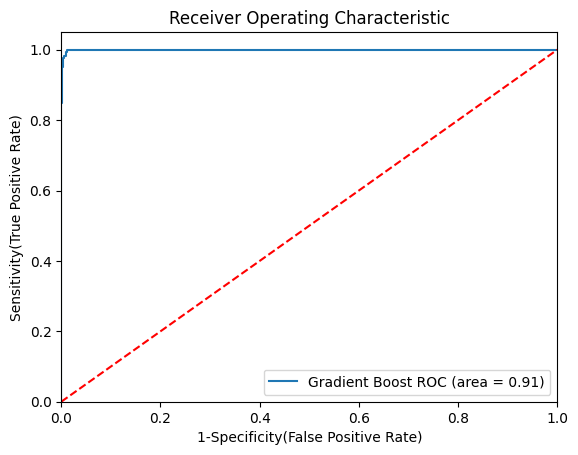

In [36]:
## Plot ROC AUC Curve
from sklearn.metrics import roc_auc_score,roc_curve
plt.figure()

# Add the models to the list that you want to view on the ROC plot
auc_models = [
{
    'label': 'Gradient Boost',
    'model': GradientBoostingClassifier(n_estimators=1000, min_samples_split=20, max_depth=8, loss='exponential', criterion='friedman_mse'),
    'auc':  0.9065
},
    
]
# create loop through all model
for algo in auc_models:
    model = algo['model'] # select the model
    model.fit(X_train_scaled, y_train_pred) # train the model
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = roc_curve(y_test_pred, model.predict_proba(X_test_scaled)[:,1])
# Calculate Area under the curve to display on the plot
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (algo['label'], algo['auc']))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig("auc.png")
plt.show()